In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Problem Description

A 1D, single-phase coreflood flow experiment is conducted with a gas.
- The core has following properties:

$
\hspace{1cm}
\begin{array}{l}
L=1.0\:\text{ft},\: a=0.02\:\text{ft}^2,\: k=50\:\text{mD},\: \phi=0.2
\end{array}
$
- The initial pressure is atmospheric, $P=14.7\:\text{psia}$.
- A constant pressure, $P=200\:\text{psia}$, is imposed at $x=0$ and the pressure is maintained at atmospheric, $14.7\:\text{psia}$, at $x=L$.
- The fluid viscosity is approximately constant, $\mu_g=0.01\:\text{cp}$, and the gas acts ideally at these low pressures.
- For the purposes of this problem, the formation volume factor, $B_g$, can be assumed uniform.
- Klinkenberg effects can be neglected.

Determine the pressure field after three iterations of the first timestep using the Picard and Newton's method.
- Use four uniform blocks, a timestep of $\Delta t=1\text{E-}5\:\text{days}$, and an initial guess of $P=14.7\:\text{psia}$.

# Input Parameters

In [2]:
#Grid Properties:
gnum = 4
size = 1.
area = 0.02

In [3]:
# Reservoir Rock Properties
poro = 0.2
perm = 50.0

In [4]:
# Reservoir Fluid Properties
visc = 0.01

In [5]:
# Constraints - Exterior Boundary Conditions
pL = 200
pR = 14.7

In [6]:
# Numerical Settings
tstep = 1e-5 # days
nstep = 3

In [7]:
# Initial reservoir conditioins
pinit = 14.7 # psi

# Matrix Construction

In [8]:
# Field units: unit conversion factor for consistency
md_to_ft2 = 1.06235016e-14
day_to_sec = 24*60*60
cp_to_psi_sec = 1.4503774389728e-7
cp_to_psi_day = cp_to_psi_sec/day_to_sec
factor = md_to_ft2/cp_to_psi_day

In [9]:
# transmissibility value
t = (perm*area)/(visc*size/gnum); t

400.0

In [10]:
t = t*factor; t

2.5313977274496575

In [11]:
# storage value
a = area*size/gnum*poro/tstep; a

100.0

In [12]:
# Filling Arrays
def filler(gnum,t,pL,pR):

    # Initialization of Arrays
    T = np.zeros((gnum,gnum))
    J = np.zeros((gnum,gnum))
    Q = np.zeros((gnum,1))

    for i in range(gnum):
        if i==0:
            T[i,i] = t
            T[i,i+1] = -t
            J[i,i] = 2*t
            Q[i,0] = 2*t*pL
        elif i==gnum-1:
            T[i,i] = t
            T[i,i-1] = -t
            J[i,i] = 2*t
            Q[i,0] = 2*t*pR
        else:
            T[i,i] = 2*t
            T[i,i+1] = -t
            T[i,i-1] = -t

    return T,J,Q

In [13]:
T,J,Q = filler(gnum,t,pL,pR)

In [14]:
T

array([[ 2.53139773, -2.53139773,  0.        ,  0.        ],
       [-2.53139773,  5.06279545, -2.53139773,  0.        ],
       [ 0.        , -2.53139773,  5.06279545, -2.53139773],
       [ 0.        ,  0.        , -2.53139773,  2.53139773]])

In [15]:
J

array([[5.06279545, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 5.06279545]])

In [16]:
Q

array([[1012.55909098],
       [   0.        ],
       [   0.        ],
       [  74.42309319]])

In [17]:
P0 = np.full((gnum,1),pinit)

# Solver Functions

In [18]:
# Implicit Pressure Calculation Function
def pressure(T,J,A,Q,P):
    return np.linalg.solve((T+J+A),np.matmul(A,P)+Q)

In [19]:
# Residual Vector Calculation Function
def residual(T,J,A,Q,P,Pk):
    return -np.matmul((T+J+A),Pk)+np.matmul(A,P)+Q

# Picard Method

In [20]:
P = np.copy(P0)

for n in range(nstep):
    Pk = np.copy(P)
    # print(f"TIME STEP - {t+1}")
    for k in range(100):
        # Fluid Property Calculation
        ct = 1/Pk.flatten()
        A = np.diag(a*ct)
        # Residual Calculation
        F = residual(T,J,A,Q,P,Pk)
        error = np.linalg.norm(F,2)
        print(f"{k:2}",f"{error:.5e}",Pk.flatten())
        if error<1e-6:
            break
        # Pressure calculation
        Pk = pressure(T,J,A,Q,P)
            
    P = np.copy(Pk)
    print(f"{n:10}",P.flatten())

 0 9.38136e+02 [14.7 14.7 14.7 14.7]
 1 3.82903e+02 [82.53311832 29.88986565 18.06691483 15.2920019 ]
 2 7.84572e+01 [132.23387485  52.95834541  24.24686398  16.40989552]
 3 2.47493e+01 [142.86827257  66.89411718  29.85375902  17.50245286]
 4 8.88718e+00 [145.3658956   72.22752944  33.06165573  18.19276961]
 5 3.24765e+00 [146.11675443  74.06338575  34.47801554  18.52449572]
 6 1.18016e+00 [146.36710065  74.69858643  35.03206855  18.66141982]
 7 4.26313e-01 [146.45405669  74.92203804  35.23805716  18.71379019]
 8 1.53503e-01 [146.48480883  75.00147601  35.31308058  18.7331215 ]
 9 5.51897e-02 [146.49577481  75.02986871  35.34017897  18.74014549]
10 1.98295e-02 [146.49970019  75.0400428   35.34993382  18.74268037]
11 7.12260e-03 [146.50110778  75.04369285  35.35344045  18.74359256]
12 2.55807e-03 [146.50161293  75.04500304  35.35470027  18.74392042]
13 9.18674e-04 [146.50179429  75.04547345  35.35515277  18.74403821]
14 3.29914e-04 [146.5018594   75.04564237  35.35531528  18.74408051]
1

# Newton's Method

In [21]:
# Jacobian Calculation (Ideal Gas)
def jacobian(T,J,A,P,Pk):
    return -(T+J)-A*P.flatten()/Pk.flatten()

In [22]:
P = np.copy(P0)

for n in range(nstep):
    Pk = np.copy(P)
    # print(f"TIME STEP - {n+1}")
    for k in range(100):
        # Fluid Property Calculation
        ct = 1/Pk.flatten()
        A = np.diag(a*ct)
        # Residual calculation
        F = residual(T,J,A,Q,P,Pk)
        error = np.linalg.norm(F,2)
        print(f"{k:2}",f"{error:.5e}",Pk.flatten())
        if error<1e-6:
            break
        # Pressure calculation
        Z = jacobian(T,J,A,P,Pk)
        Pk += np.linalg.solve(Z,-F)
    P = np.copy(Pk)
    print(f"{n:10}",P.flatten())

 0 9.38136e+02 [14.7 14.7 14.7 14.7]
 1 3.82903e+02 [82.53311832 29.88986565 18.06691483 15.2920019 ]
 2 3.42849e+01 [142.13814037  63.96364099  28.01252312  17.11703556]
 3 2.53308e+00 [146.33764957  74.55201314  34.6944062   18.55523794]
 4 1.69400e-02 [146.50108404  75.04328443  35.35139616  18.74256369]
 5 7.53199e-07 [146.50189586  75.04573692  35.35540619  18.74410414]
         0 [146.50189586  75.04573692  35.35540619  18.74410414]
 0 1.35789e+02 [146.50189586  75.04573692  35.35540619  18.74410414]
 1 2.03433e+01 [165.69335077 102.25497981  53.13947868  23.89476155]
 2 7.29592e-01 [167.34136664 106.94704415  58.39472282  25.6623581 ]
 3 9.65329e-04 [167.38126817 107.07157386  58.57779285  25.74502883]
 4 1.74028e-09 [167.38130658 107.07169506  58.57799064  25.74514937]
         1 [167.38130658 107.07169506  58.57799064  25.74514937]
 0 5.79775e+01 [167.38130658 107.07169506  58.57799064  25.74514937]
 1 5.12112e+00 [172.77273686 119.59064866  71.02740096  30.85979552]
 2 3.9873

# Generalized Solution

In [23]:
def solver(gnum,tstep,nstep,method="picard"):

    t = (perm*area)/(visc*size/gnum)*factor
    T,J,Q = filler(gnum,t,pL,pR)
    a = area*size/gnum*poro/tstep
    
    P0 = np.full((gnum,1),pinit)

    P = np.copy(P0)
    
    for n in range(nstep):
        Pk = np.copy(P)
        for k in range(100):
            # Fluid Property Calculation
            ct = 1/Pk.flatten()
            A = np.diag(a*ct)
            # Residual calculation
            F = residual(T,J,A,Q,P,Pk)
            error = np.linalg.norm(F,2)
            if error<1e-6:
                break
            # Method dependent pressure calculation
            if method=="explicit":
                Pk = pressure(T,J,A,Q,P)
                break
            elif method=="picard":
                Pk = pressure(T,J,A,Q,P)
            elif method=="newton":
                Z = jacobian(T,J,A,P,Pk)
                Pk += np.linalg.solve(Z,-F)
        P = np.copy(Pk)

    xnodes = np.linspace(0,size,gnum+1)
    
    return (xnodes[1:]+xnodes[:-1])/2,P.flatten()

Plotting Results:

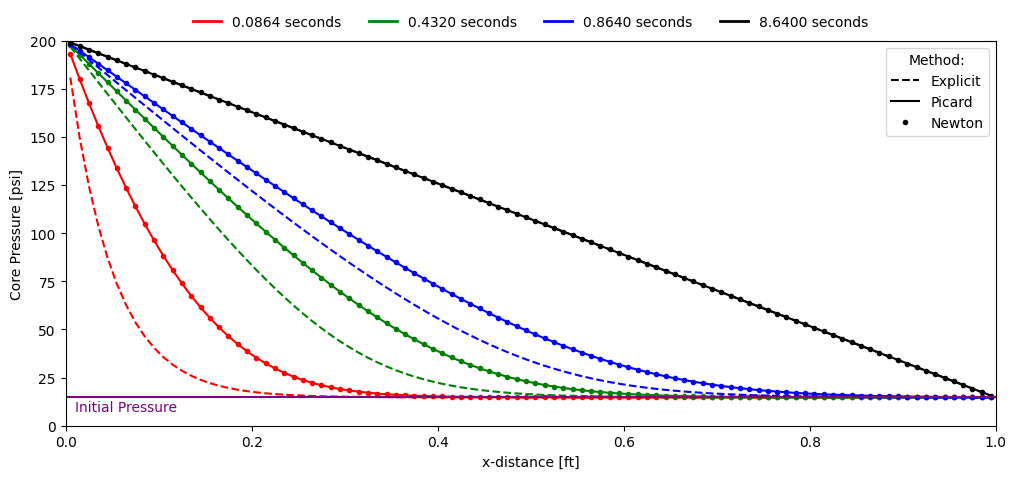

In [24]:
fig, ax = plt.subplots(figsize=(12, 5))

x1,P1 = solver(100,1e-6,1,method="explicit")
x2,P2 = solver(100,1e-6,1,method="picard")
x3,P3 = solver(100,1e-6,1,method="newton")

ax.plot(x1,P1,"r--",label='Explicit')
ax.plot(x2,P2,"r",label='Picard')
ax.plot(x3,P3,"r.",label='Newton')

x1,P1 = solver(100,1e-6,5,method="explicit")
x2,P2 = solver(100,1e-6,5,method="picard")
x3,P3 = solver(100,1e-6,5,method="newton")

ax.plot(x1,P1,"g--",label='Explicit')
ax.plot(x2,P2,"g",label='Picard')
ax.plot(x3,P3,"g.",label='Newton')

x1,P1 = solver(100,1e-6,10,method="explicit")
x2,P2 = solver(100,1e-6,10,method="picard")
x3,P3 = solver(100,1e-6,10,method="newton")

ax.plot(x1,P1,"b--",label='Explicit')
ax.plot(x2,P2,"b",label='Picard')
ax.plot(x3,P3,"b.",label='Newton')

x1,P1 = solver(100,1e-6,100,method="explicit")
x2,P2 = solver(100,1e-6,100,method="picard")
x3,P3 = solver(100,1e-6,100,method="newton")

line1, = ax.plot(x1,P1,"k--",label='Explicit')
line2, = ax.plot(x2,P2,"k",label='Picard')
line3, = ax.plot(x3,P3,"k.",label='Newton')

ax.hlines(pinit,0,size,color='purple')
ax.text(0.01, pinit*0.9, "Initial Pressure", color="purple", ha="left",va="top")

ax.set_ylabel("Core Pressure [psi]")
ax.set_xlabel("x-distance [ft]")

ax.set_xlim((0,size))
ax.set_ylim((0,pL))

legend1 = ax.legend([line1,line2,line3],["Explicit","Picard","Newton"],title="Method:",loc="upper right")

# Create secondary legend for colors representing time
rpatch = plt.Line2D([0],[0],color="r",lw=2,label=f"{1*1e-6*24*60*60:.4f} seconds")
gpatch = plt.Line2D([0],[0],color="g",lw=2,label=f"{5*1e-6*24*60*60:.4f} seconds")
bpatch = plt.Line2D([0],[0],color="b",lw=2,label=f"{10*1e-6*24*60*60:.4f} seconds")
kpatch = plt.Line2D([0],[0],color="k",lw=2,label=f"{100*1e-6*24*60*60:.4f} seconds")

legend2 = ax.legend(handles=[rpatch,gpatch,bpatch,kpatch],loc="upper center",bbox_to_anchor=(0.5, 1.1),ncol=4,frameon=False)

ax.add_artist(legend1)

plt.show()